In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
from datetime import datetime
from pandas_datareader.data import DataReader

symbol='AAPL'    
start='2016-01-01'
end=datetime.now()
df = DataReader(symbol, 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-06,127.129997,125.650002,126.500000,126.209999,80171300.0,126.209999
2021-04-07,127.919998,125.139999,125.830002,127.900002,83466700.0,127.900002
2021-04-08,130.389999,128.520004,128.949997,130.360001,88844600.0,130.360001
2021-04-09,133.039993,129.470001,129.800003,133.000000,106513800.0,133.000000
2021-04-12,132.850006,130.630005,132.520004,131.246704,62190382.0,131.246704


In [2]:
df = df['Open'].values
df = df.reshape(-1, 1)
print(df.shape)
df[:5]

(1327, 1)


array([[25.65250015],
       [26.4375    ],
       [25.13999939],
       [24.67000008],
       [24.63750076]])

In [3]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1061, 1)
(316, 1)


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.05371901],
       [0.06709551],
       [0.04498593],
       [0.03697708],
       [0.03642329]])

In [5]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.92544943],
       [0.93976321],
       [0.94419368],
       [0.96574943],
       [0.94508825]])

In [6]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [7]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.05371901, 0.06709551, 0.04498593, 0.03697708, 0.03642329,
        0.0382125 , 0.04494336, 0.04396353, 0.03390986, 0.02641219,
        0.03582689, 0.02172616, 0.03007582, 0.03676407, 0.04907556,
        0.04230212, 0.0257306 , 0.01614553, 0.02040556, 0.02756242,
        0.02308937, 0.02130016, 0.02496379, 0.0277754 , 0.01333389,
        0.01827554, 0.02521938, 0.01614553, 0.01784955, 0.02138535,
        0.02841441, 0.03765867, 0.0255602 , 0.0268808 , 0.02726421,
        0.01695494, 0.02577321, 0.03067222, 0.02922383, 0.03258926,
        0.04477295, 0.04507115, 0.05269661, 0.0527818 , 0.04592315,
        0.04818096, 0.04860699, 0.05214279, 0.050737  , 0.05947005]])

In [8]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.92544943, 0.93976321, 0.94419368, 0.96574943, 0.94508825,
        0.95250066, 0.96391752, 0.96783681, 0.97375818, 0.97094668,
        0.9808725 , 0.93746275, 0.94828327, 0.99876468, 0.98210794,
        0.98376929, 0.91292492, 0.95982792, 0.99480276, 0.9907558 ,
        0.98990374, 0.95501407, 0.99514363, 0.98606974, 0.99765703,
        1.        , 0.96004087, 0.97980749, 0.99101139, 0.97392862,
        0.88293439, 0.89865392, 0.83722419, 0.81409225, 0.71253309,
        0.81911905, 0.91024121, 0.87944113, 0.87552184, 0.81792625,
        0.74018066, 0.79722255, 0.79828756, 0.70690981, 0.74503716,
        0.64731193, 0.6709977 , 0.63802509, 0.67048652, 0.66959189]])

In [9]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
if(not os.path.exists('stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=9, batch_size=32)
    model.save('stock_prediction.h5')

In [13]:
model = load_model('stock_prediction.h5')

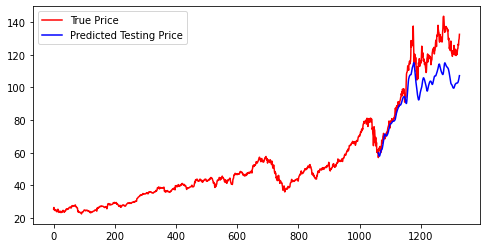

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions,color='blue', label='Predicted Testing Price')
plt.legend()

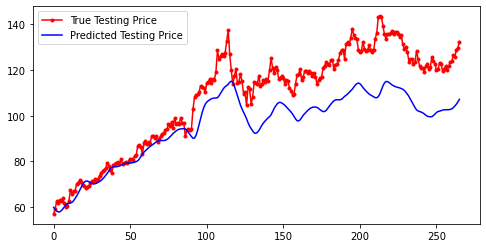

In [15]:

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled,'.-', color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [22]:
from sklearn import metrics
r_square = metrics.r2_score(y_test_scaled, predictions)
print('R-Square Error:', r_square)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_scaled, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_scaled, predictions)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_scaled, predictions))
rmse = np.sqrt(np.mean(((y_test_scaled-predictions) ** 2)))
print(rmse)

R-Square Error: 0.5425767762029015
Mean Absolute Error: 12.4497195222324
Root Mean Squared Error: 15.045539605010664
Mean Squared Error: 226.36826200594444
15.045539605010664


In [17]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data = np.expand_dims(x, axis=0)
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[107.20807, 136.98735, 155.17299, 163.78827, 168.26518, 170.63243, 171.94858, 172.69666, 173.13301, 173.3921, 173.54883, 173.64531, 173.70566, 173.74393, 173.76881, 173.78516, 173.79597, 173.80334, 173.8085, 173.8123, 173.81519, 173.81757, 173.81973, 173.82211, 173.8246, 173.8275, 173.83104, 173.83545, 173.84102, 173.84859, 173.85846, 173.87115, 173.8884, 173.91298, 173.946, 173.99135, 174.05286, 174.14084, 174.26619, 174.41908, 174.56941, 174.6963, 174.78647, 174.842, 174.87515, 174.89275, 174.89949, 174.89847, 174.8914, 174.87842, 174.85881, 174.84091, 174.83223, 174.82797, 174.82556, 174.82425, 174.82336, 174.82286, 174.82246, 174.82211, 174.82187, 174.82169, 174.8215, 174.82135, 174.82121, 174.82103, 174.82094, 174.82079, 174.82065, 174.82048, 174.82034, 174.8202, 174.8201, 174.81993, 174.8198, 174.81963, 174.81946, 174.81927, 174.81914, 174.81892, 174.81874, 174.81853, 174.81833, 174.81812, 174.81786, 174.81764, 174.81737, 174.81714, 174.81699, 174.8168, 174.8167, 174.81665, 174.8

In [18]:
# x1 = np.linspace(0.0, 5.0)
# x2 = np.linspace(0.0, 2.0)

# y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
# y2 = np.cos(2 * np.pi * x2)

# plt.subplot(2, 1, 1)
# plt.plot(x1, y1, 'o-')
# plt.title('A tale of 2 subplots')
# plt.ylabel('Damped oscillation')

# plt.subplot(2, 1, 2)
# plt.plot(x2, y2, '.-')
# plt.xlabel('time (s)')
# plt.ylabel('Undamped')

# plt.show()

95.45898608130965